# Introdução

Vamos explorar aqui como criar um classificador básico utilizando o *dataset* [Titanic](https://www.kaggle.com/c/titanic) do Kaggle. Esse é um problema de classificação simples, binária, onde devemos prever se um passageiro do navio irá ou não sobreviver, dado um conjunto de características (*features*) que ele possui (idade, sexo, porto de embarque etc.).

Nessa implementação vamos utilizar a biblioteca scikit-learn, com o classificador [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

A ideia é mostrar, numa abordagem top-down, como é rápida a criação de um classificador que prevê um resultado de um problema, sem muito conhecimento prévio, e já obtendo resultados minimamente aceitáveis.

Durante a solução do problemas, serão apresentados conceitos relacionados a implementação de um classificador em *Machine Learning*:

- exploração dos dados;
- pré-processamento de dados
- importância da separação dos *sets* de treino e validação;
- *overfitting*;
- dentre outros.

Vamos lá!

# Bibliotecas Utilizadas

O código foi implementado em Python 3, utilizando as seguintes bibliotecas:

- pandas
- scikit-learn

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# os dados estão na pasta data

PATH = "data/"
!ls {PATH}

test.csv  train.csv


# Iniciando o pré-processamento

Vamos ler os arquivos de treino e de teste. Ambos são arquivos *.csv*; geralmente, o Kaggle disponibiliza em seus problemas os arquivos de treino e teste separados, de forma que o modelo seja treinado e melhorado com os dados do arquivo de treino e validado junto aos dados do arquivo de teste.

Vamos utilizar um [DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) do [pandas](https://pandas.pydata.org/). No código abaixo, a saída do arquivo é direcionada para dois *DataFrames* distintos: df_train e df_test.

**Nota**: Um *DataFrame* é uma estrutura de dados bidimensional, com linhas e colunas. Para efeitos de comparação, pense em *DataFrame* como uma tabela de um banco de dados relacional ou uma planilha.

In [3]:
import pandas as pd

df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

Para facilitar o pré-processamento, vamos juntar os 2 *DataFrames* em um só. Isso costuma ser uma **boa prática**, pois, temos as seguintes vantagens:

- remoção de colunas: às vezes, optamos por remover uma coluna por algum motivo; ao retirar uma coluna dos dados de treino, precisamos também removê-la dos dados de teste (ambos os conjunto de dados precisam ter o mesmo conjunto de colunas - *features*, sob pena de termos um erro ao tentar construir o modelo);
- remoção/tratamento uniforme de dados nulos;
- consistência na criação de variáveis categóricas (se todas as categorias não estiverem presentes nos dois conjuntos de dados, elas podem ser codificadas de forma diferente se isso for feito em duas operações em separado) - isso vai ficar mais claro adiante;

Portanto, juntar os 2 conjunto de dados uniformiza e padroniza o tratamento, de forma que o modelo criado lide de forma consistente nos dois casos.

In [4]:
df_raw = df_train.append(df_test, sort = False)
len(df_train), len(df_test), len(df_raw) # listando o tamanho de cada um dos datasets

(891, 418, 1309)

Vamos listar as colunas (*features*) presente em nosso *data set*.

In [5]:
df_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Visão geral dos dos dados

Antes de começarmos a trabalhar com os dados, é bom termos uma visão geral dos dados.

Vamos dar uma olhada geral nos dados que temos.

In [6]:
df_raw.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
191,1083,NaN,1,"Salomon, Mr. Abraham L",male,NaN,0,0,111163,26.0000,NaN,S
549,550,1.0,2,"Davies, Master. John Morgan Jr",male,8.00,1,1,C.A. 33112,36.7500,NaN,S
99,991,NaN,3,"Nancarrow, Mr. William Henry",male,33.00,0,0,A./5. 3338,8.0500,NaN,S
492,493,0.0,1,"Molson, Mr. Harry Markland",male,55.00,0,0,113787,30.5000,C30,S
701,702,1.0,1,"Silverthorne, Mr. Spencer Victor",male,35.00,0,0,PC 17475,26.2875,E24,S
78,79,1.0,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
106,107,1.0,3,"Salkjelsvik, Miss. Anna Kristine",female,21.00,0,0,343120,7.6500,NaN,S
470,471,0.0,3,"Keefe, Mr. Arthur",male,NaN,0,0,323592,7.2500,NaN,S
6,898,NaN,3,"Connolly, Miss. Kate",female,30.00,0,0,330972,7.6292,NaN,Q
265,1157,NaN,3,"Lyntakoff, Mr. Stanko",male,NaN,0,0,349235,7.8958,NaN,S


A listagem acima é uma exibição **aleatória** (*sample(10)*) de 10 linhas; é interessante porque nos permite ter uma visão geral dos tipos dos dados que temos (numéricos, categóricos, textuais), presença de valores nulos etc.

Podemos visualizar, também, um **sumário estatístico dos dados**. Para isso, usamos o método *describe()* do *DataFrame*. Esse método nos retorna um outro DataFrame com diversas estatísticas: número de entradas, média, desvio-padrão, valor mínimo, valor máximo e percentis.

In [7]:
df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


**Nota**: colunas com valores não numéricos são excluídas dessa visualização (veja que a coluna *Name* não aparece, por exemplo).

Vamos listar as colunas com **valores nulos**.

In [8]:
(df_raw.isnull().sum()/len(df_raw)).sort_values(ascending=False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
PassengerId    0.000000
dtype: float64

Das saídas anteriores, podemos tirar algumas conclusões:

- As colunas *Age*, *Cabin*, *Embarked* possuem valores nulos (*Survived* é a nossa variável dependente, isto é, o valor que queremos prever; esses valores nulos referem-se às entradas do arquivo de teste);
- A coluna *Sex*, *Ticket* e *Embarked* devem ser categorizadas - os algoritmos de *Machine Learning* precisam de entradas do tipo numérico - não sabem lidar com texto;
- As colunas *Name*  e *PassengerId*, em princípio, não fazem sentido. Provavelmente nossa variável dependente, *Survived*, não se relaciona com elas. Logo, podemos removê-las.

### Tratando os nulos

A maioria das bibliotecas de *Machine Learning*, incluindo a scikit-learn, disparam erros ao usar dados com valores nulos. Por isso precisamos tratar esses valores. Temos algumas alternativas:

- **remover as linhas** com valores nulos (essa não costuma ser uma boa ideia, pois, estamos jogando fora linhas que possuem outras informações por causa de valores nulos em determinadas colunas);
- **remover as colunas** que possuem valores nulos (sob pena de perda de informação, caso elas sejam úteis);
- ***Imputation***: preencher os valores nulos com algum valor; por exemplo, podemos substituir os nulos presentes em uma coluna pela média, mediana ou moda dos valores da coluna; esse procedimento nos dá um melhor resultado do que a simples remoção da coluna;

Vamos usar as duas últimas alternativas acima. 

**Nota**: dado ao alto índice de valores nulos (77%), vamos optar por remover a coluna *Cabin*;

In [9]:
df_copy = df_raw.copy()
df_copy.drop('Cabin', axis=1, inplace=True)

df_copy.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Uma boa prática, antes de fazer os tratamentos necessários nos dados, é criar uma cópia dos dados originais, de forma que estes fiquem intactos. Foi isso que fizemos ao criar a variável *df_copy*.

Para as colunas *Age* e *Fare*, vamos colocar no lugar dos valores nulos a média das idades presentes.

In [10]:
age_not_null = df_copy[df_copy['Age'].isnull() == False]['Age']
fare_not_null = df_copy[df_copy['Fare'].isnull() == False]['Fare']
mean_age = age_not_null.mean()
mean_fare = fare_not_null.mean()
df_copy.fillna(value = {'Age':mean_age, 'Fare' : mean_fare}, inplace=True) # substituímos os nulos pela média

Para a coluna *Embarked*, do tipo categórica, podemos usar a moda.

Vamos visualizar os dados presentes nessa coluna.

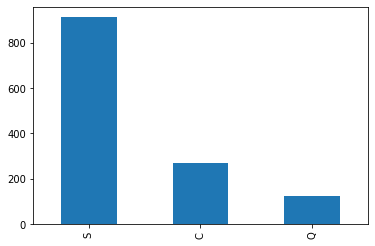

In [11]:
df_copy['Embarked'].value_counts().plot.bar()

O valor mais comun, a moda, é o valor 'S'. Vamos substituir os valores nulos por 'S'.

In [12]:
df_copy.fillna(value={'Embarked': 'S'}, inplace=True)

Vamos ver agora os valores nulos que temos.

In [13]:
(df_copy.isnull().sum()/len(df_copy)).sort_values(ascending=False)

Survived       0.319328
Embarked       0.000000
Fare           0.000000
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Age            0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
PassengerId    0.000000
dtype: float64

Pronto. Tratamos todos os nulos. Podemos prosseguir com o pré-processamento de dados.

**Nota**: lembre-se que a coluna *Survived* tem valores nulos provenientes dos dados do arquivo de teste - é o que vamos prever.

### Lidando com variáveis categóricas

Variáveis categóricas são aquelas cujos valores são limitados a um conjunto de valores. Um exemplo de variável categórica em nosso conjunto de dados é *Embarked*, que representa o porto de embarque; os seus valores são 'S', 'C' e 'Q'.

Assim como no caso dos valores nulos, passar variáveis categóricas para modelos de *Machine Learning* também resultam em erros. Por isso precisamos tratar esses valores.

A forma mais popular de tratamento de variáveis categóricas é o **One-Hot Encoding**.

**One-Hot Encoding** cria novas colunas, binárias, indicando a presença ou ausência de cada um dos valores categóricos no conjunto de dados original. É uma boa técnica quando o conjunto de valores categóricos não é muito grande - caso contrário, vamos ter uma explosão de colunas.

Primeiramente, vamos visualizar os tipos de dados de cada uma das nossas colunas (*features*).

In [14]:
df_copy.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

As variáveis do tipo **object** indicam que elas possuem texto. Essas, em geral, são colunas que devem passar pelo processo de *encoding*.

In [15]:
# Vamos verificar a quantidade de valores únicos em cada uma dessas colunas object.
unique_values = {}
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        unique_values[col] = len(df_copy[col].unique())
        
unique_values

{'Name': 1307, 'Sex': 2, 'Ticket': 929, 'Embarked': 3}

Se fizemos *one-hot encoding* diretamente, as colunas *Name* e *Ticket* vão gerar diversas colunas binárias. Logo, não é uma boa ideia usar o encoding nelas.

Primeiramente, vamos ignorar a coluna *Name*. Vamos fazer isso porque o hot-encoding dela geraria uma explosão de colunas; e, também, porque conforme dissemos anteriomente, acreditamos que ela não deve estar relacionada com a variável alvo, não devendo ter, portanto, importância para o modelo (o nome da pessoa não deve influenciar se ela sobrevive ou não).

Depois, vamos categorizar as variáveis *Ticket* e *Sex*.

In [16]:
df_copy.drop('Name', axis=1, inplace=True)
df_copy.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [17]:
# Transformamos texto em categoria
df_copy['Ticket'] = df_copy['Ticket'].astype('category')
df_copy['Sex'] = df_copy['Sex'].astype('category')
# Substitui os valores pelos códigos de cada categoria
df_copy['Ticket'] = df_copy['Ticket'].cat.codes
df_copy['Sex'] = df_copy['Sex'].cat.codes

In [18]:
df_copy.sample(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
416,417,1.0,2,0,34.000000,1,1,305,32.5000,S
568,569,0.0,3,1,29.881138,0,0,281,7.2292,C
47,939,NaN,3,1,29.881138,0,0,640,7.7500,Q
281,1173,NaN,3,1,0.750000,1,1,883,13.7750,S
362,363,0.0,3,0,45.000000,0,1,286,14.4542,C
358,359,1.0,3,0,29.881138,0,0,381,7.8792,Q
214,215,0.0,3,1,29.881138,1,0,611,7.7500,Q
702,703,0.0,3,0,18.000000,0,1,286,14.4542,C
190,191,1.0,2,0,32.000000,0,0,156,13.0000,S
58,59,1.0,2,0,5.000000,1,2,768,27.7500,S


Como podemos ver, as variáveis *Ticket* e *Sex* tiveram seus valores substituídos pelos códigos numéricos correspondentes.

Agora, finalmente, vamos aplicar o one-hot encoding no DataFrame.

In [19]:
df_copy = pd.get_dummies(df_copy)

A função *get_dummies* do pandas permite fazer *one-hot encoding*, convertendo variáveis categóricas em variáveis indicadores (*dummy*).

In [20]:
df_copy.sample(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S
849,850,1.0,1,0,29.881138,1,0,108,89.1042,1,0,0
257,1149,NaN,3,1,28.000000,0,0,586,8.0500,0,0,1
551,552,0.0,2,1,27.000000,0,0,196,26.0000,0,0,1
237,1129,NaN,3,1,20.000000,0,0,274,7.2250,1,0,0
609,610,1.0,1,0,40.000000,0,0,805,153.4625,0,0,1
706,707,1.0,2,0,45.000000,0,0,140,13.5000,0,0,1
580,581,1.0,2,0,25.000000,1,1,175,30.0000,0,0,1
204,1096,NaN,2,1,25.000000,0,0,765,10.5000,0,0,1
244,245,0.0,3,1,30.000000,0,0,289,7.2250,1,0,0
169,1061,NaN,3,0,22.000000,0,0,696,8.9625,0,0,1


Compare essa saída com a saída do penúltimo *sample()*.

Observe, nessa última saída, que foram criadas variáveis adicionais derivadas de *Embarked*:  

- *Embarked_C*: indicando que o valor original era 'C';
- *Embarked_Q*: indicando que o valor original era 'Q';
- *Embarked_S*: indicando que o valor original era 'S';

Em cada linha, somente uma dessas variáveis terá seu valor igual a 1, com as outras tendo o valor 0.

Agora, com todas as variáveis tendo valores numéricos, podemos partir para o treino do modelo.

# Treinando um modelo

Finalmente podemos treinar o modelo. Vamos, primeiramente, separar novamente os data sets de treino e teste, conforme os arquivos originalmente nos fornecidos pelo Kaggle.

In [21]:
df_train = df_copy[0:891] # o tamanho original do arquivo de treino é 891
df_test = df_copy[891:]

A partir de agora, vamos utilizar o conjunto de treino para fazer o treino do nosso modelo.

### Definindo as features

In [22]:
cols_to_remove = ['PassengerId', 'Survived']

features = [c for c in df_train.columns if c not in cols_to_remove]
print(features)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


No trecho anterior removemos as variáveis *PassengerId* (pelo fato de acreditarmos que ela não se relaciona com a nossa variável alvo - é apenas um sequencial numérico) e a variável alvo *Survived*. O objetivo é selecionar as *features* que vamos utilizar para treinar nosso modelo.

### Usando o RandomForestClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

# usando n_estimators = 100, para suprimir warning
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df_train[features], df_train['Survived'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

No trecho anterior, criamos um classificador do tipo RandomForest e em seguida chamamos o seu método *fit*, para fazer o **treino** do modelo - a construção das árvores, neste caso.

COLOCAR LINK RANDOM FOREST

O primeiro argumento de *fit* é a entrada para o treino (X); o segundo argumento é a variável alvo (y).

Agora vamos fazer a **previsão** do resultado.

In [24]:
train_predictions = model.predict(df_train[features])

A função *predict()* nos retorna os valores que queremos prever, neste caso, o valor de *Survived*.

Esse é o padrão para treino de modelos utilizando scikit-learn: chamar *fit* para fazer o ajuste e depois *predict* para fazer a previsão.

FIGURA FIT-PREDICT

Vamos ver a acurácia das nossas previsões no dataset de treino.

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(df_train['Survived'], train_predictions)

0.9988776655443322

Usamos como métrica a acurácia - essa é a métrica recomendada pelo Kaggle para esse problema. Fizemos uso do *accuracy_score* do scikit-learn; o seu primeiro argumento são os valores reais; o segundo argumento são os valores previstos, obtidos como saída do classificador.

Nesse caso, o modelo está conseguindo acertar 99% das previsões.

O que fizemos até agora nos garante que o nosso modelo tem um ótimo desempenho nos dados do conjunto de treino - quase 100%. Esse são os dados conhecidos. 

No entanto, precisamos garantir que o modelo também se comporte bem para dados que ele ainda não conhece; em outras palavras, queremos um modelo/classificador que generalize bem para novos dados que lhe sejam apresentados - evitar o ***overfitting***.

Para avaliar quão bom é o desempenho do modelo treinado em dados desconhecidos, vamos separar o conjunto de dados de treino em 2 outros conjuntos separados: treino e teste.

### train_test_split: Criando os conjuntos de treino e teste

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train['Survived'], test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712,), (179,))

Fizemos uso da função *train_test_split* do scikit-learn para separar, aleatoriamente, o dataset de treino df_train em outros dois datasets independentes: X_train e X_test (80% dos dados vão ser usados para o treino; 20% para fazer o teste/validação do modelo).

Agora, vamos treinar o modelo utilizando o X_train e avaliá-lo utilizando o X_test.

In [29]:
model.fit(X_train, y_train)

accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

(0.9985955056179775, 0.8044692737430168)

Como vemos, o desempenho no set de treino é bem maior do que no set de teste: 99% vs 80% - embora precisão de 80% seja um resultado razoável. O que está ocorrendo aqui é o ***overfitting***.

O ***overfitting*** ocorre quando o modelo captura bem as características presentes no set de treinamento, mas falha ao generalizar seu comportamento para dados que ele desconhece - fazendo uma analogia, é como se ele decorasse as características existentes, em vez de aprendê-las.

Há diversas formas de tratar o overfitting, como melhora de hiperparâmetros, melhor tratamento de dados, etc. Não vamos entrar nesse tópico, para não fugir do nosso objetivo, que é a criação de um classificador simples e rápido.

### Verificando se o classificador criado é bom

Vimos que o classificador tem uma acurácia de 80% no dataset de teste. 80%, para a maioria dos problemas, parece ser um bom resultado. Mas quão bom é esse valor?

Vamos comparar o nosso classificador com um classificador que *dummy*, isto é, um classificador que sempre prevê o mesmo valor (por exemplo, ele sempre "chuta" que o passageiro vai morrer). Esperamos que o nosso classificador seja melhor que esse, caso contrário, não faz sentido utilizá-lo.

Vamos dar uma olhada nos nossos dados.

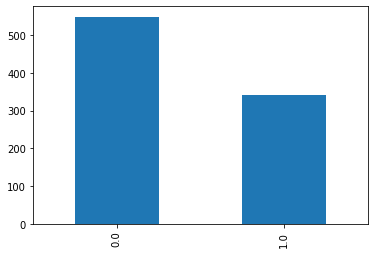

In [30]:
df_train['Survived'].value_counts().plot.bar()

Vamos fazer um classificador que, independentemente dos dados, sempre chuta que o passageiro vai morrer.

In [31]:
from sklearn.dummy import DummyClassifier

# cria um classificador que faz previsões baseados na classe mais frequente
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

accuracy_score(y_train, dummy.predict(X_train)), accuracy_score(y_test, dummy.predict(X_test))

(0.6235955056179775, 0.5865921787709497)

Conforme podemos ver, a acurácia do classificador que sempre prevê o mesmo valor, é de 58.6% nos dados de teste. Logo, o nosso classificador baseado em RandomForest está bem melhor que esse.

Vamos fazer a análise final, que seria a submissão dos resultados para o Kaggle, baseado no arquivo com os dados de testes que nos foi fornecido (test.csv).

## Resultado junto ao arquivo de teste

In [32]:
output_predictions = model.predict(df_test[features])
print(output_predictions)

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.

In [36]:
my_submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': output_predictions})
my_submission.Survived = my_submission.Survived.astype(int)

In [37]:
# escrevendo o arquivo de saída
my_submission.to_csv(f'{PATH}submission.csv', index=False)

Pronto. O arquivo está pronto para ser enviado para o Kaggle.

**Nota**: A título de curiosidade, o score desse classificador no Kaggle foi 0.7751. Ou seja, acurácia de 77.5%. Cabe lembrar que não fizemos nenhuma otimização no nosso classificador. Apenas tratamos os dados e fizemos a classificação. Então é um resultado bastante aceitável para uma primeira experiência.